In [1]:
import netCDF4 as nc4
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd
import time
# import xarray as xr

In [43]:
# Data path
# GSWP3
f_sanrafael = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/sanrafael.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/sanrafael.test.1958_2013.nc'
f_villamadero = '/pscratch/sd/s/sshu3/e3sm_scratch/pm-cpu/villamadero.pm-cpu.Ea00a6ed2f-F23ee93f0.2023-10-21/run/hist/villamadero.test.1958_2013.nc'
# TerraClimate
# Wind speed is at 10m.
f_terra_tmax_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmax_'
f_terra_tmin_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_tmin_'
f_terra_prec_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ppt_'
f_terra_wind_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_ws_'
f_terra_rad_pre = '/pscratch/sd/s/sshu3/Terraclimate/TerraClimate_srad_'
suf = '.nc'
# ERA (1979 - 2022)
f_era_tbot_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/tbot/elmforc.ERA5.c2018.0.25d.t2m.'
f_era_prec_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/prec/elmforc.ERA5.c2018.0.25d.mcpr.'
f_era_wind_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/wind/elmforc.ERA5.c2018.0.25d.v10.'
f_era_rad_pre = '/global/cfs/cdirs/e3sm/inputdata/atm/datm7/atm_forcing.datm7.ERA.0.25d.v5.c180614/swdn/elmforc.ERA5.c2018.0.25d.msdwswrf.'

# Sr - 19.26932, -98.61660 
# Vm - 19.35500, -101.27070
# Rio Frio - 19.34, -98.66
latid_sr = int((90.0-19.0)*24.0) - round(0.34/(1.0/24.0))
lonid_sr = int((180.0-98.0)*24.0) - round(0.66/(1.0/24.0))
latid_vm = int((90.0-19.0)*24.0) - round(0.355/(1.0/24.0))
lonid_vm = int((180.0-101.0)*24.0) - round(0.2707/(1.0/24.0))

# For ERA
latid_sr_era = int((90.0+19.0)*4.0) + round(0.34/(1.0/4.0))
lonid_sr_era = int((360.0-98.0)*4.0) - round(0.66/(1.0/4.0))
latid_vm_era = int((90.0+19.0)*4.0) + round(0.355/(1.0/4.0))
lonid_vm_era = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For GPCC-2020
latid_sr_gpcc = int((90.0-19.0)*4.0) - round(0.34/(1.0/4.0))
lonid_sr_gpcc = int((360.0-98.0)*4.0) - round(0.66/(1.0/4.0))
latid_vm_gpcc = int((90.0-19.0)*4.0) - round(0.355/(1.0/4.0))
lonid_vm_gpcc = int((360.0-101.0)*4.0) - round(0.2707/(1.0/4.0))

# For Chirps-v2
latid_sr_chirps = int((50.0+19.0)*20.0) + round(0.26932/(1.0/20.0))
lonid_sr_chirps = int((180.0-98.0)*20.0) - round(0.6166/(1.0/20.0))
latid_vm_chirps = int((50.0+19.0)*20.0) + round(0.355/(1.0/20.0))
lonid_vm_chirps = int((180.0-101.0)*20.0) - round(0.2707/(1.0/20.0))

In [56]:
# Other data
f_quart_gpcc = '/global/homes/s/sshu3/precip.mon.ltm.0.25x0.25.v2020.nc'
dtc = nc4.Dataset(f_quart_gpcc)
gpcc = dtc['precip'][:]
sr_gpcc = gpcc[:,latid_sr_gpcc,lonid_sr_gpcc]
lon_sr = dtc['lon'][lonid_sr_gpcc]
lat_sr = dtc['lat'][latid_sr_gpcc]
dtc.close()

f_chirps = '/global/homes/s/sshu3/chirps-v2.0.annual.nc'
dtc = nc4.Dataset(f_chirps)
ch = dtc['precip'][:]
sr_chirps = ch[:,latid_sr_chirps+1,lonid_sr_chirps+1]
lon_sr = dtc['longitude'][lonid_sr_chirps]
lat_sr = dtc['latitude'][latid_sr_chirps+1]
dtc.close()

In [63]:
# Obtain GSWP3 data
# Daily temperature averaged over a month
dsr = nc4.Dataset(f_sanrafael)
sr_tbot = np.squeeze(dsr['TBOT'][:])
sr_tmax = np.squeeze(dsr['TREFMXAV'][:])
sr_tmin = np.squeeze(dsr['TREFMNAV'][:])
sr_prec = np.squeeze(dsr['RAIN'][:])
sr_wind = np.squeeze(dsr['WIND'][:])
sr_rad = np.squeeze(dsr['FSDS'][:])
dsr.close()
dvm = nc4.Dataset(f_villamadero)
vm_tbot = np.squeeze(dvm['TBOT'][:])
vm_tmax = np.squeeze(dvm['TREFMXAV'][:])
vm_tmin = np.squeeze(dvm['TREFMNAV'][:])
vm_prec = np.squeeze(dvm['RAIN'][:])
vm_wind = np.squeeze(dvm['WIND'][:])
vm_rad = np.squeeze(dvm['FSDS'][:])
dvm.close()


In [62]:
# Obtain TerraClimate data
yrbeg = 1958
yrend = 2022
nlen = 12 * (yrend - yrbeg + 1)
sr_tmax_terra = np.zeros((nlen))
sr_tmin_terra = np.zeros((nlen))
sr_prec_terra = np.zeros((nlen))
sr_wind_terra = np.zeros((nlen))
sr_rad_terra = np.zeros((nlen))
vm_tmax_terra = np.zeros((nlen))
vm_tmin_terra = np.zeros((nlen))
vm_prec_terra = np.zeros((nlen))
vm_wind_terra = np.zeros((nlen))
vm_rad_terra = np.zeros((nlen))

for i in np.arange(1958,yrend):
    pbeg = (i-yrbeg)*12
    pend = (i-yrbeg+1)*12
    # Tmax
    fp = f_terra_tmax_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmax = dtc['tmax']
    # lon_sr = dtc['lon'][lonid_sr]
    # lat_sr = dtc['lat'][latid_sr]
    sr_tmax_terra[pbeg:pend] = dtmax[:,latid_sr,lonid_sr]
    vm_tmax_terra[pbeg:pend] = dtmax[:,latid_vm,lonid_vm]
    dtc.close()
    # Tmin
    fp = f_terra_tmin_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dtmin = dtc['tmin']
    sr_tmin_terra[pbeg:pend] = dtmin[:,latid_sr,lonid_sr]
    vm_tmin_terra[pbeg:pend] = dtmin[:,latid_vm,lonid_vm]
    dtc.close()
    # Prec, accumulated mm per month
    fp = f_terra_prec_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dprec = dtc['ppt']
    sr_prec_terra[pbeg:pend] = dprec[:,latid_sr,lonid_sr]
    vm_prec_terra[pbeg:pend] = dprec[:,latid_vm,lonid_vm]
    dtc.close()
    # Wind, 10 m wind speed, m s-1
    fp = f_terra_wind_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    dwind = dtc['ws']
    sr_wind_terra[pbeg:pend] = dwind[:,latid_sr,lonid_sr]
    vm_wind_terra[pbeg:pend] = dwind[:,latid_vm,lonid_vm]
    dtc.close()
    # Radiation, , m s-1
    fp = f_terra_rad_pre+str(i)+suf
    dtc = nc4.Dataset(fp)
    drad = dtc['srad']
    sr_rad_terra[pbeg:pend] = drad[:,latid_sr,lonid_sr]
    vm_rad_terra[pbeg:pend] = drad[:,latid_vm,lonid_vm]
    dtc.close()


In [58]:
# Obtain ERA data
start = time.time()

yrbeg = 2013
yrend = 2014
nlen = 12 * (yrend - yrbeg)
sr_tmax_era = np.zeros((nlen))
sr_tmin_era = np.zeros((nlen))
sr_prec_era = np.zeros((nlen))
sr_wind_era = np.zeros((nlen))
sr_rad_era = np.zeros((nlen))
vm_tmax_era = np.zeros((nlen))
vm_tmin_era = np.zeros((nlen))
vm_prec_era = np.zeros((nlen))
vm_wind_era = np.zeros((nlen))
vm_rad_era = np.zeros((nlen))

for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        pbeg = (i-yrbeg)*12+j-1
        
        # Monthly mean Tmax and Tmin
        if(j < 10):
            fp = f_era_tbot_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_tbot_pre+str(i)+'-'+str(j)+suf
        dtc = nc4.Dataset(fp)
        # lon_sr = dtc['lon'][lonid_sr_era]
        # lat_sr = dtc['lat'][latid_sr_era]
        dtbot = dtc['t2m']
        temp_array_1 = dtbot[:,latid_sr_era,lonid_sr_era]
        temp_array_2 = dtbot[:,latid_vm_era,lonid_vm_era]
        dtc.close()       
        sr_tmax_era[pbeg] = np.nanmean(np.nanmax(temp_array_1.reshape(-1, 24), axis=1))
        sr_tmin_era[pbeg] = np.nanmean(np.nanmin(temp_array_1.reshape(-1, 24), axis=1))
        vm_tmax_era[pbeg] = np.nanmean(np.nanmax(temp_array_2.reshape(-1, 24), axis=1))
        vm_tmin_era[pbeg] = np.nanmean(np.nanmin(temp_array_2.reshape(-1, 24), axis=1))

        # Monthly Precipitation mm/s
        if(j < 10):
            fp = f_era_prec_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_prec_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dprec = dtc['mcpr']
        temp_array_1 = dprec[:,latid_sr_era,lonid_sr_era]
        temp_array_2 = dprec[:,latid_vm_era,lonid_vm_era]
        dtc.close()
        sr_prec_era[pbeg] = np.nansum(temp_array_1*3600.0, axis=0)
        vm_prec_era[pbeg] = np.nansum(temp_array_2*3600.0, axis=0)
        
        # Wind, 10 m wind speed, m s-1
        if(j < 10):
            fp = f_era_wind_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_wind_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        dwind_u = dtc['u10']
        dwind_v = dtc['v10']
        temp_array_1u = dwind_u[:,latid_sr_era,lonid_sr_era]
        temp_array_1v = dwind_v[:,latid_sr_era,lonid_sr_era]
        temp_array_2u = dwind_u[:,latid_vm_era,lonid_vm_era]
        temp_array_2v = dwind_v[:,latid_vm_era,lonid_vm_era]
        dtc.close()
        sr_wind_era[pbeg] = np.nanmean(np.sqrt(temp_array_1u*temp_array_1u+temp_array_1v*temp_array_1v), axis=0)
        vm_wind_era[pbeg] = np.nanmean(np.sqrt(temp_array_1u*temp_array_1u+temp_array_1v*temp_array_1v), axis=0)
        
        # Radiation, W m-2
        if(j < 10):
            fp = f_era_rad_pre+str(i)+'-0'+str(j)+suf
        else:
            fp = f_era_rad_pre+str(i)+'-'+str(j)+suf    
        dtc = nc4.Dataset(fp)
        drad = dtc['msdwswrf']
        temp_array_1 = drad[:,latid_sr_era,lonid_sr_era]
        temp_array_2 = drad[:,latid_vm_era,lonid_vm_era]
        dtc.close()
        sr_rad_era[pbeg] = np.nanmean(temp_array_1, axis=0)
        vm_rad_era[pbeg] = np.nanmean(temp_array_2, axis=0)

end = time.time()
print('Time elapsed: ', end - start)
        

Time elapsed:  175.42201113700867


(0.0, 50.0)

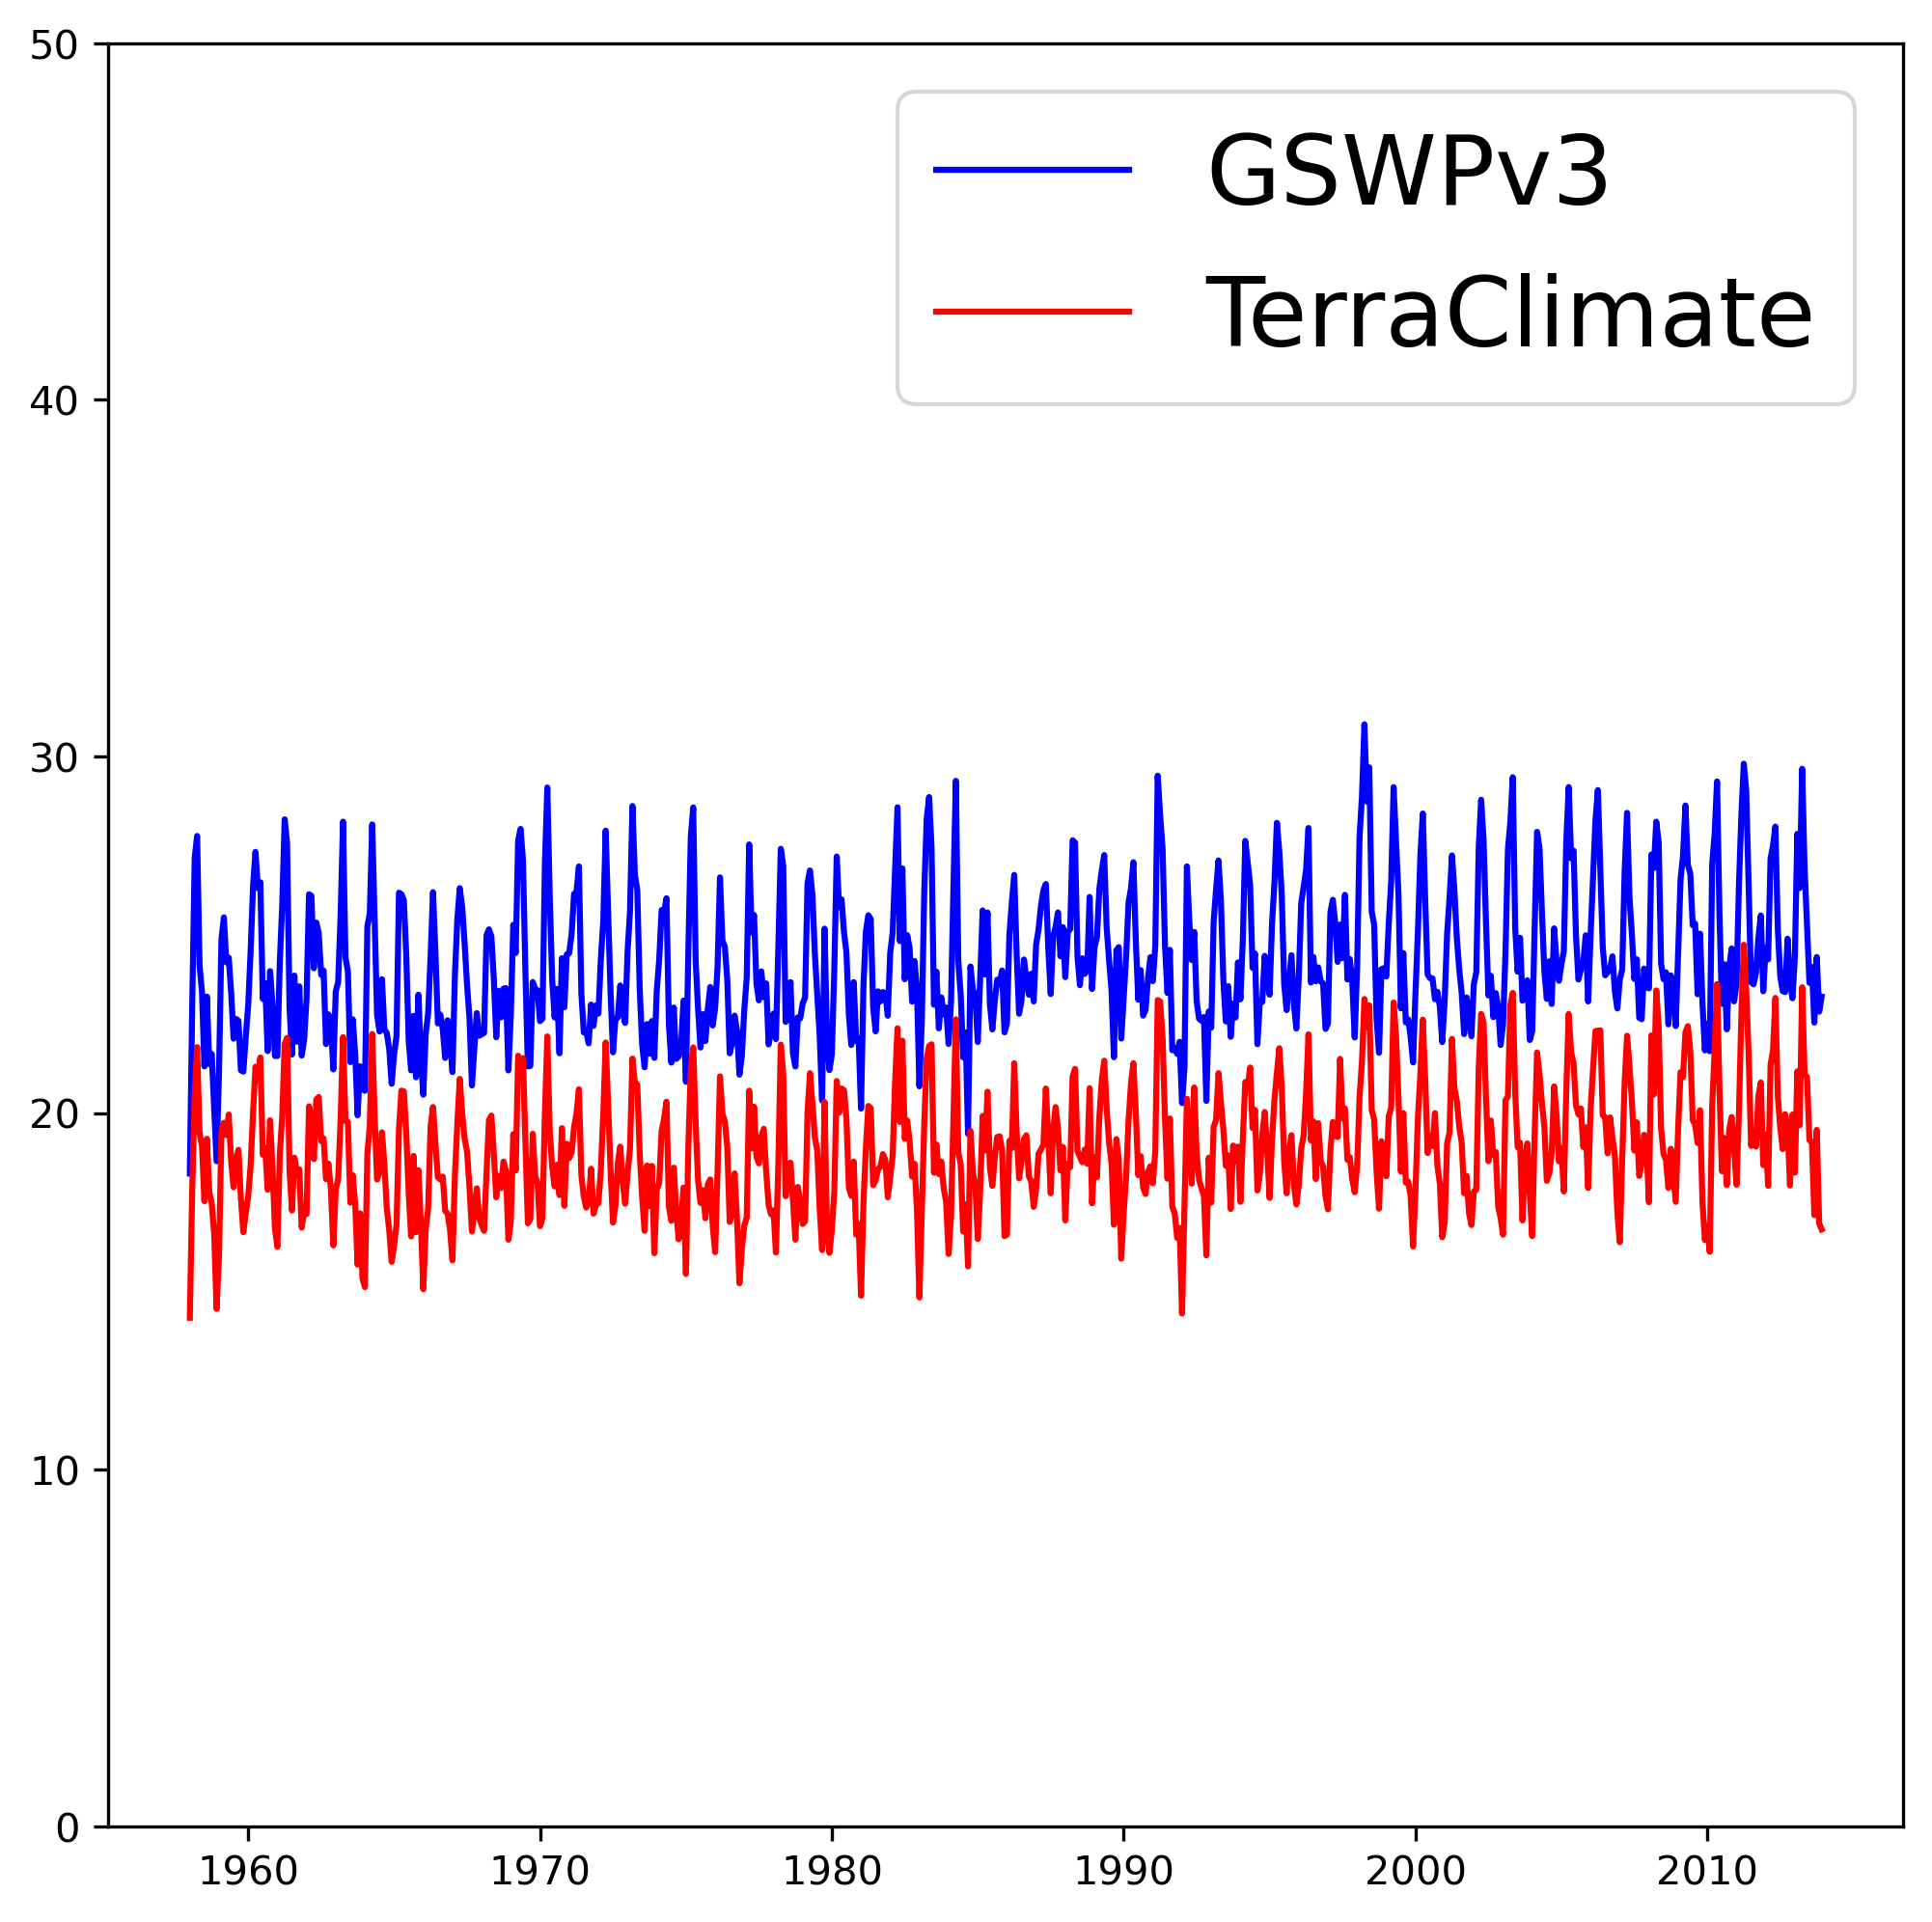

In [65]:
# Comparison
yr_axis = np.arange(1958, 2014, 1.0/12.0)
yr_axis2 = np.arange(2013, 2014, 1.0/12.0)
pltlen = len(sr_tmax)
# Tmax, not sure how terra climate calculate Tmax and Tmin, 
# but it shall be monthly mean of daily Tmax and Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_tmax[0:pltlen]-273.16, 'b-')
plt.plot(yr_axis, sr_tmax_terra[0:pltlen], 'r-')
# plt.plot(yr_axis2, sr_tmax_era[:]-273.16, 'g-')
plt.legend(['GSWPv3', 'TerraClimate', 'ERA5'], fontsize = 24)
plt.ylim([0, 50])

(-10.0, 40.0)

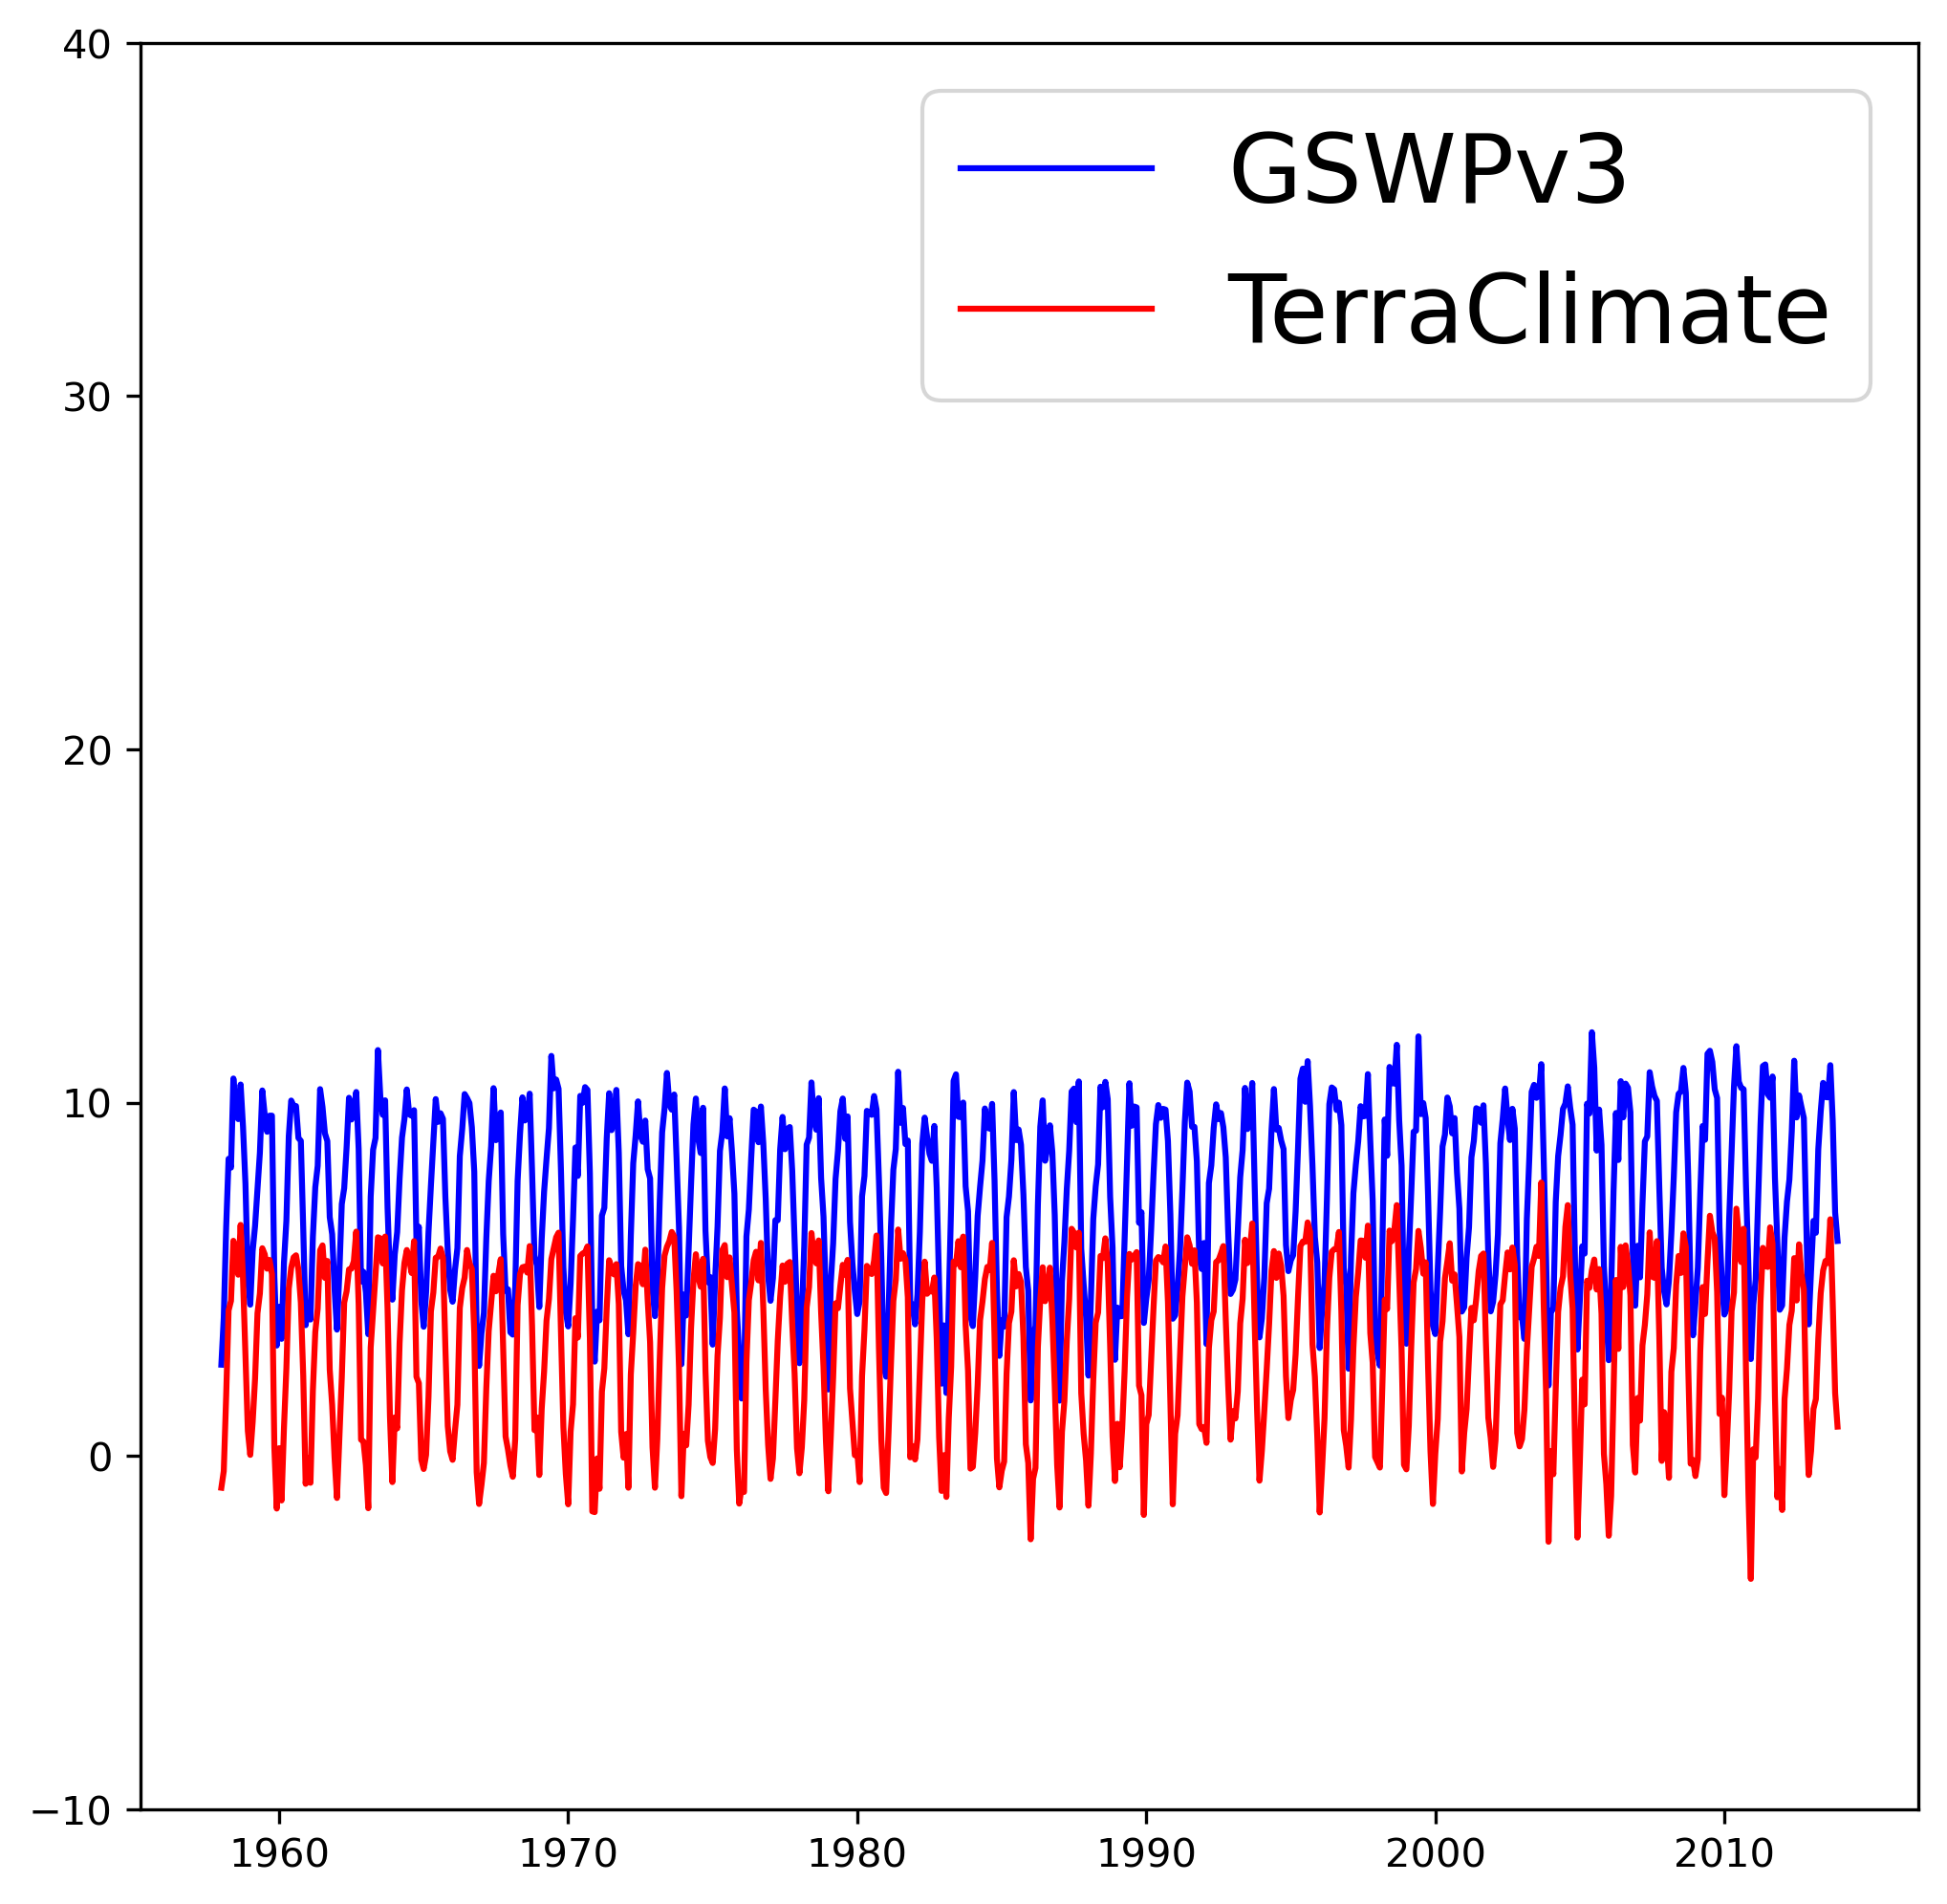

In [6]:
# Tmin
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_tmin[0:pltlen]-273.16, 'b-')
plt.plot(yr_axis, sr_tmin_terra[0:pltlen], 'r-')
# plt.plot(yr_axis2, sr_tmin_era-273.16, 'g-')
plt.legend(['GSWPv3', 'TerraClimate', 'ERA5'], fontsize = 24)
plt.ylim([-10, 40])

(0.0, 10.0)

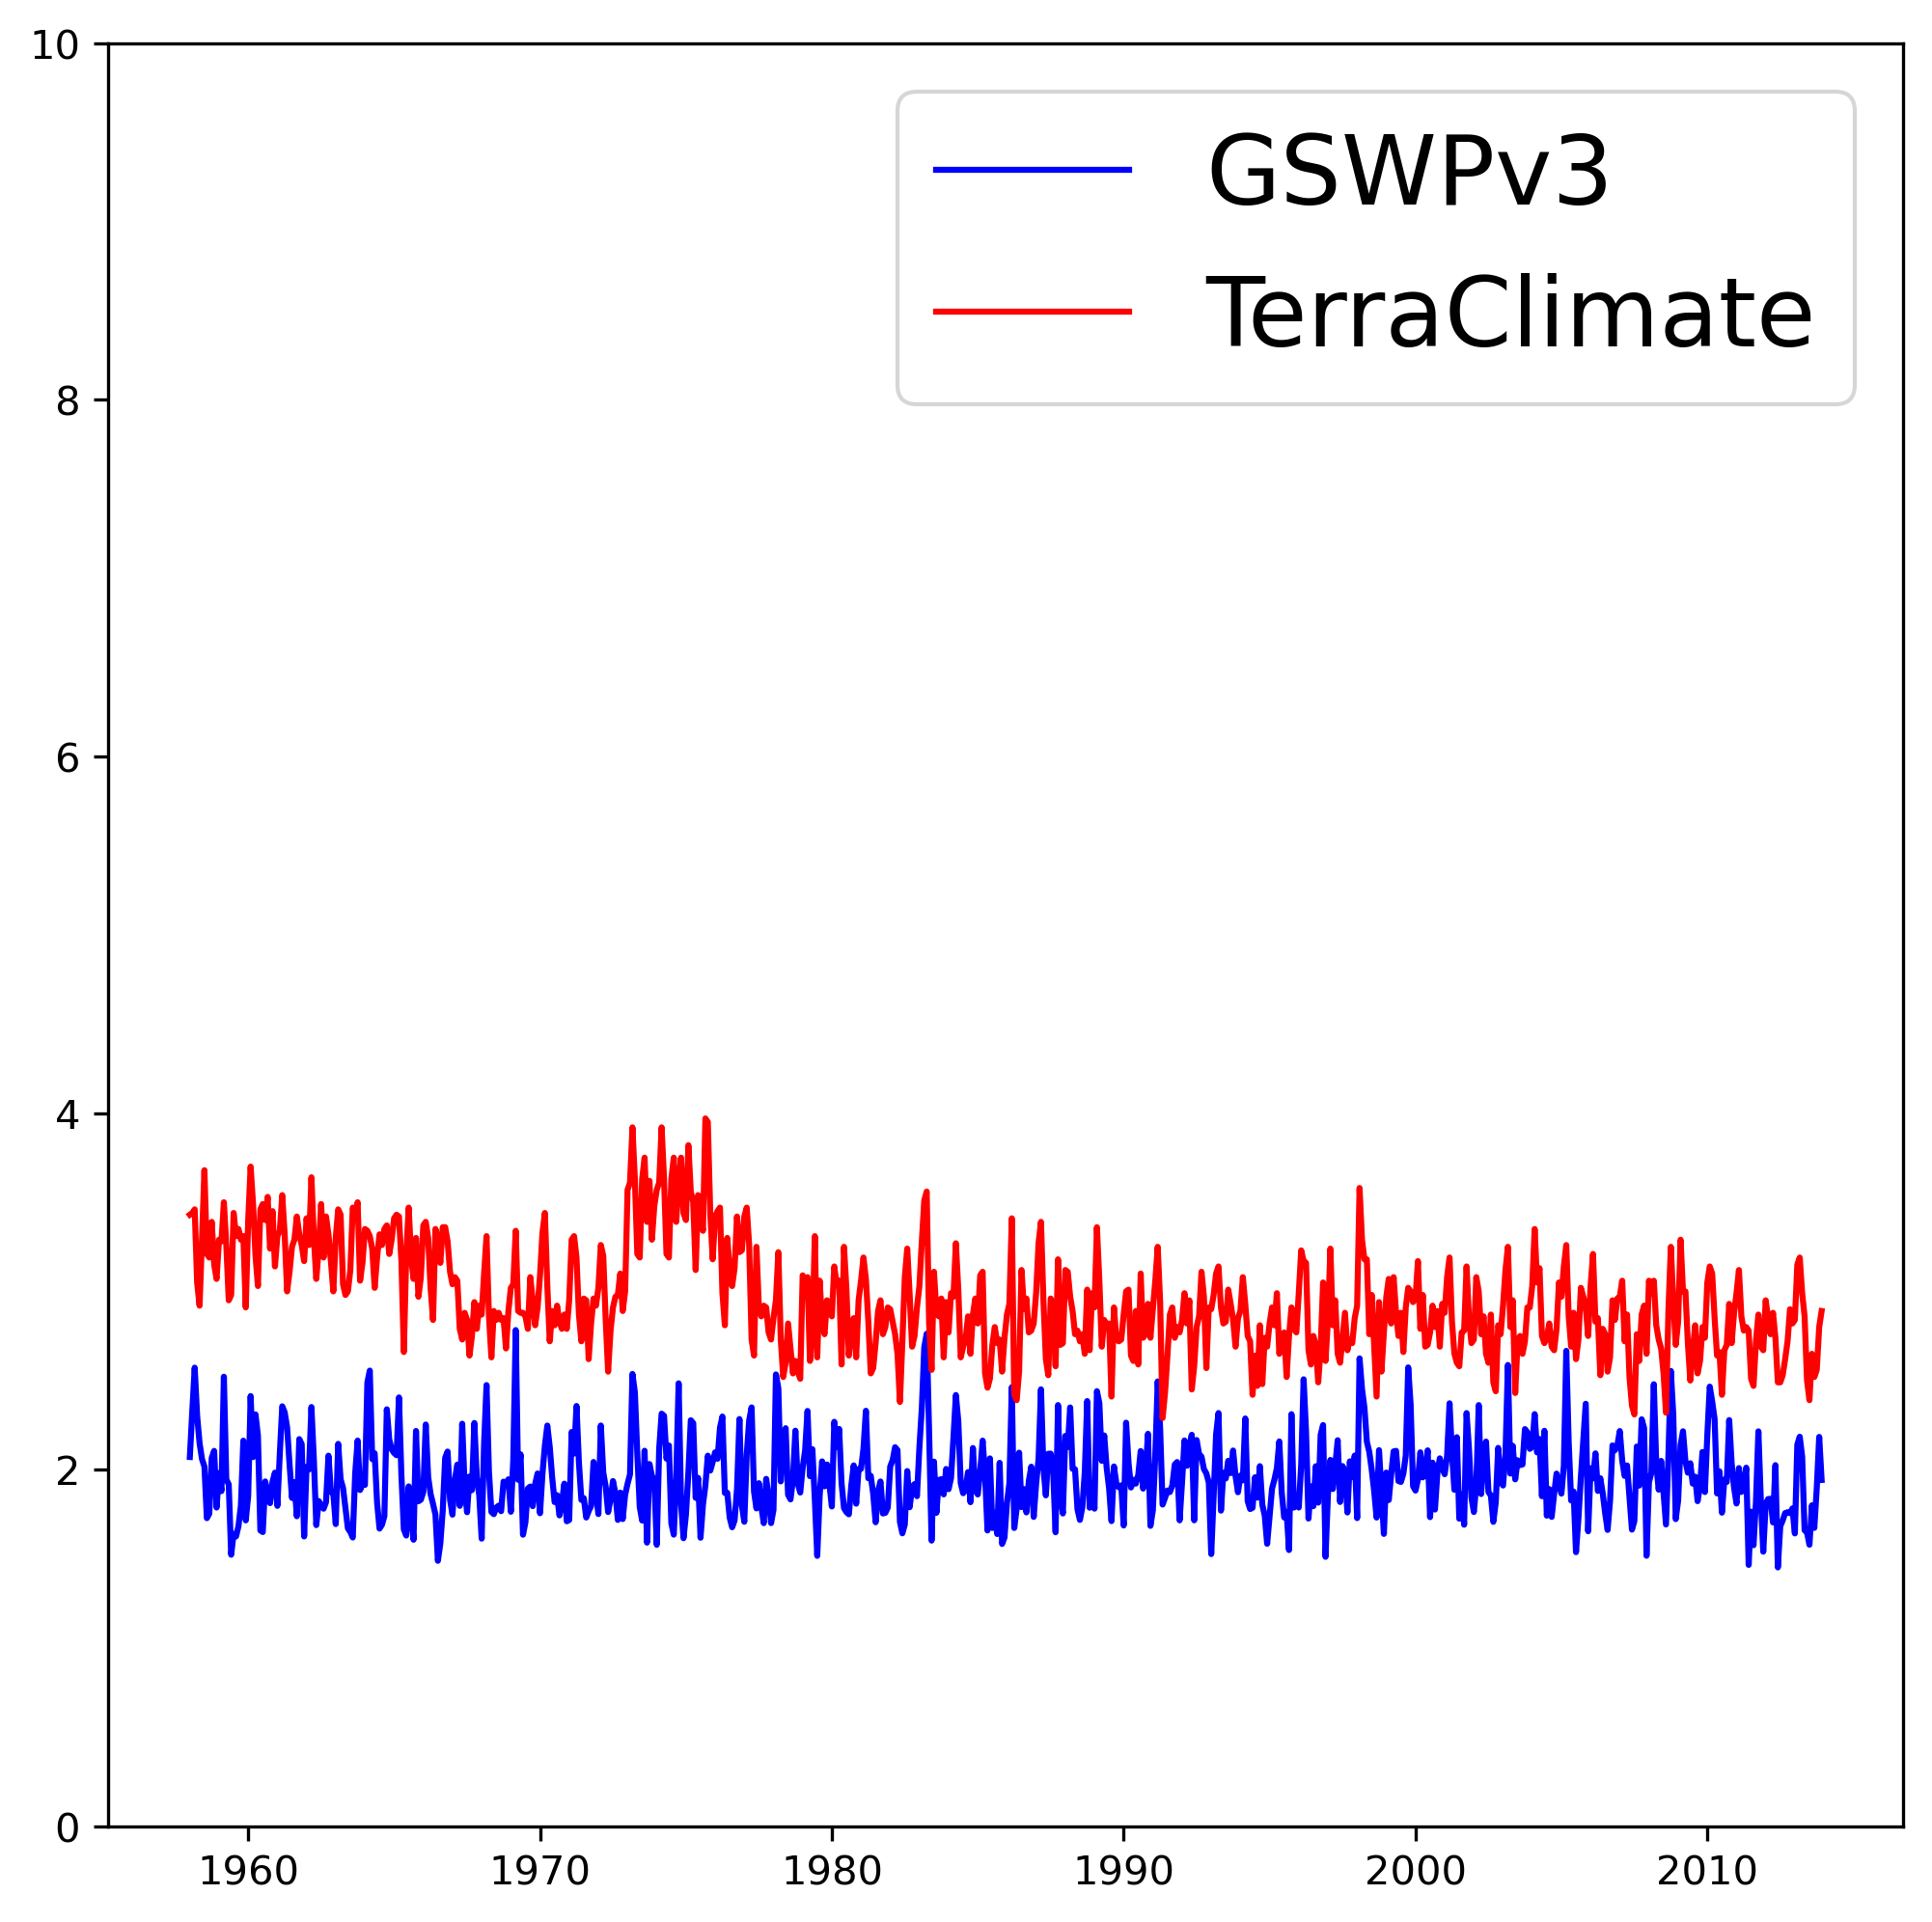

In [7]:
# Wind (GSWP vs. 10m TerraClimate)
fig = plt.figure(figsize=(8,8), dpi=300)
plt.plot(yr_axis, sr_wind[0:pltlen], 'b-')
plt.plot(yr_axis, sr_wind_terra[0:pltlen], 'r-')
# plt.plot(yr_axis2, sr_wind_era, 'g-')
plt.legend(['GSWPv3', 'TerraClimate', 'ERA5'], fontsize = 24)
plt.ylim([0, 10])

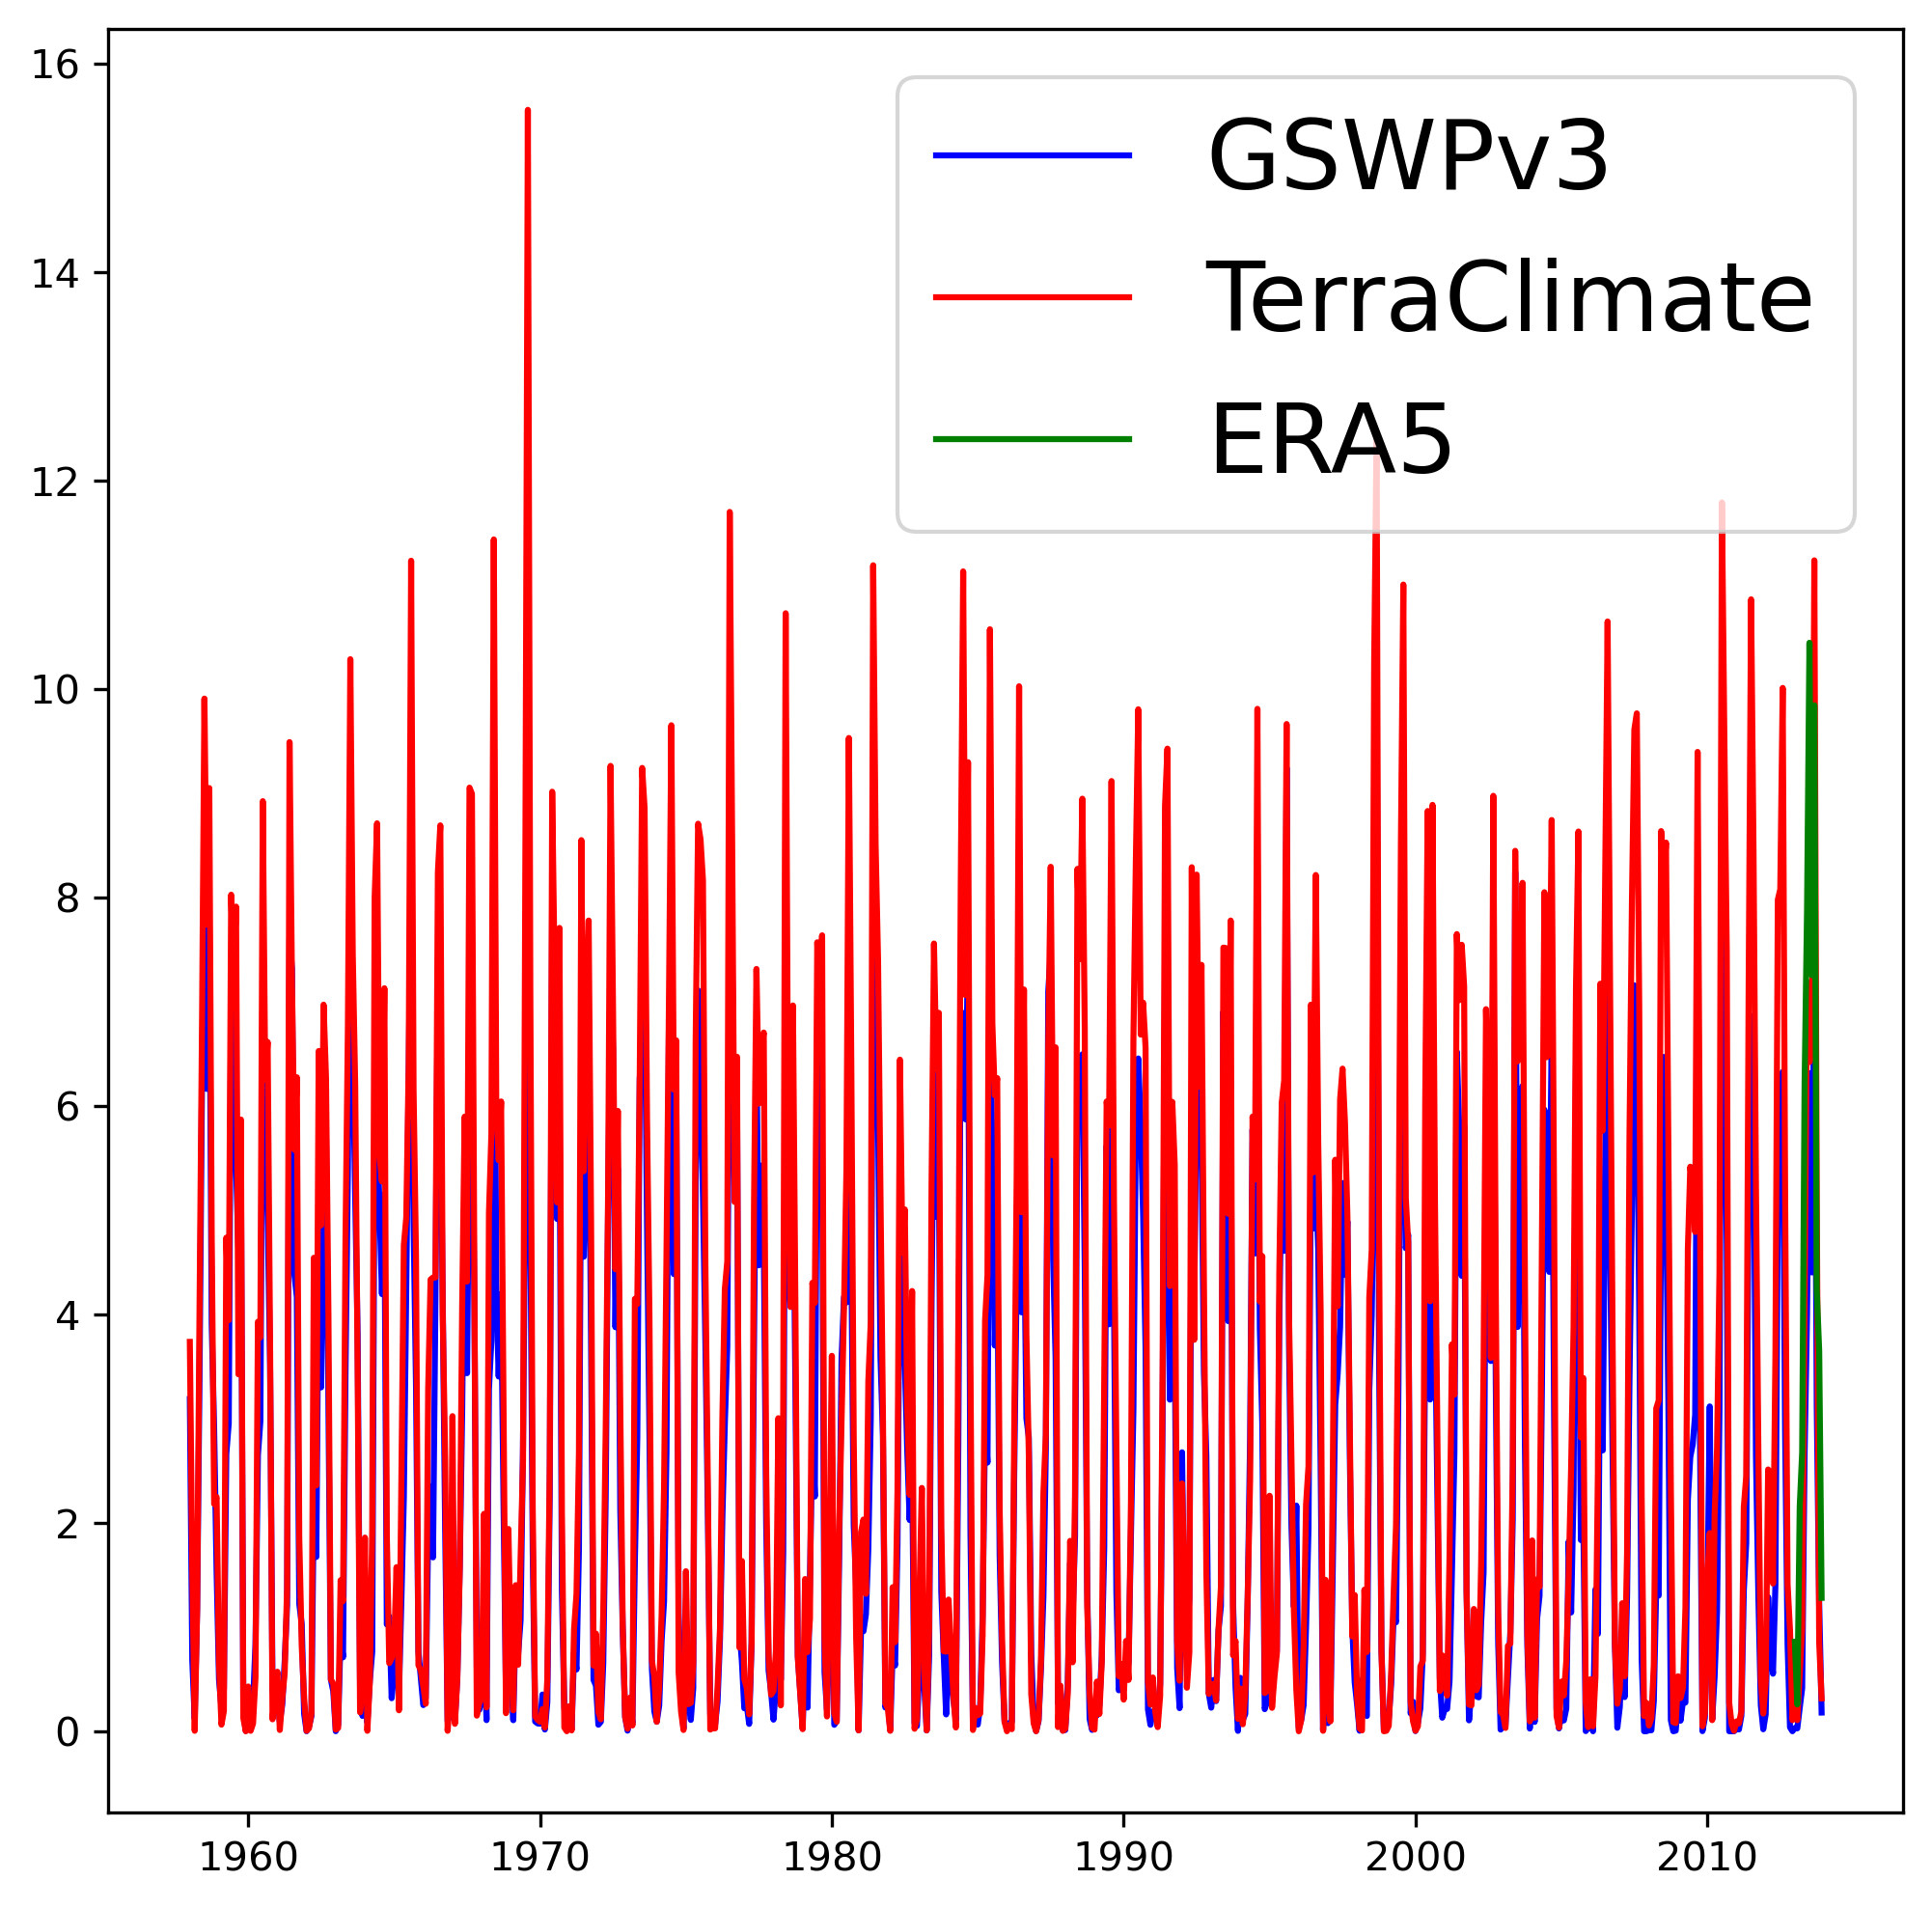

In [67]:
# Precipitation is more important, mm/month
yrbeg=1958
fig = plt.figure(figsize=(8,8), dpi=300)
secs = np.zeros((pltlen))
for i in np.arange(1958,2014):
    pbeg = (i-yrbeg)*12
    pend = (i-yrbeg+1)*12
    nday = np.array((31,28,31,30,31,30,31,31,30,31,30,31)) 
    secs[pbeg:pend] = nday*24*3600
plt.plot(yr_axis, sr_prec[0:pltlen]*secs[0:pltlen]/25.4, 'b-')
plt.plot(yr_axis, sr_prec_terra[0:pltlen]/25.4, 'r-')
plt.plot(yr_axis2, sr_prec_era/25.4, 'g-')
plt.legend(['GSWPv3', 'TerraClimate', 'ERA5'], fontsize = 24)
# plt.ylim([0, 20])

(0.0, 400.0)

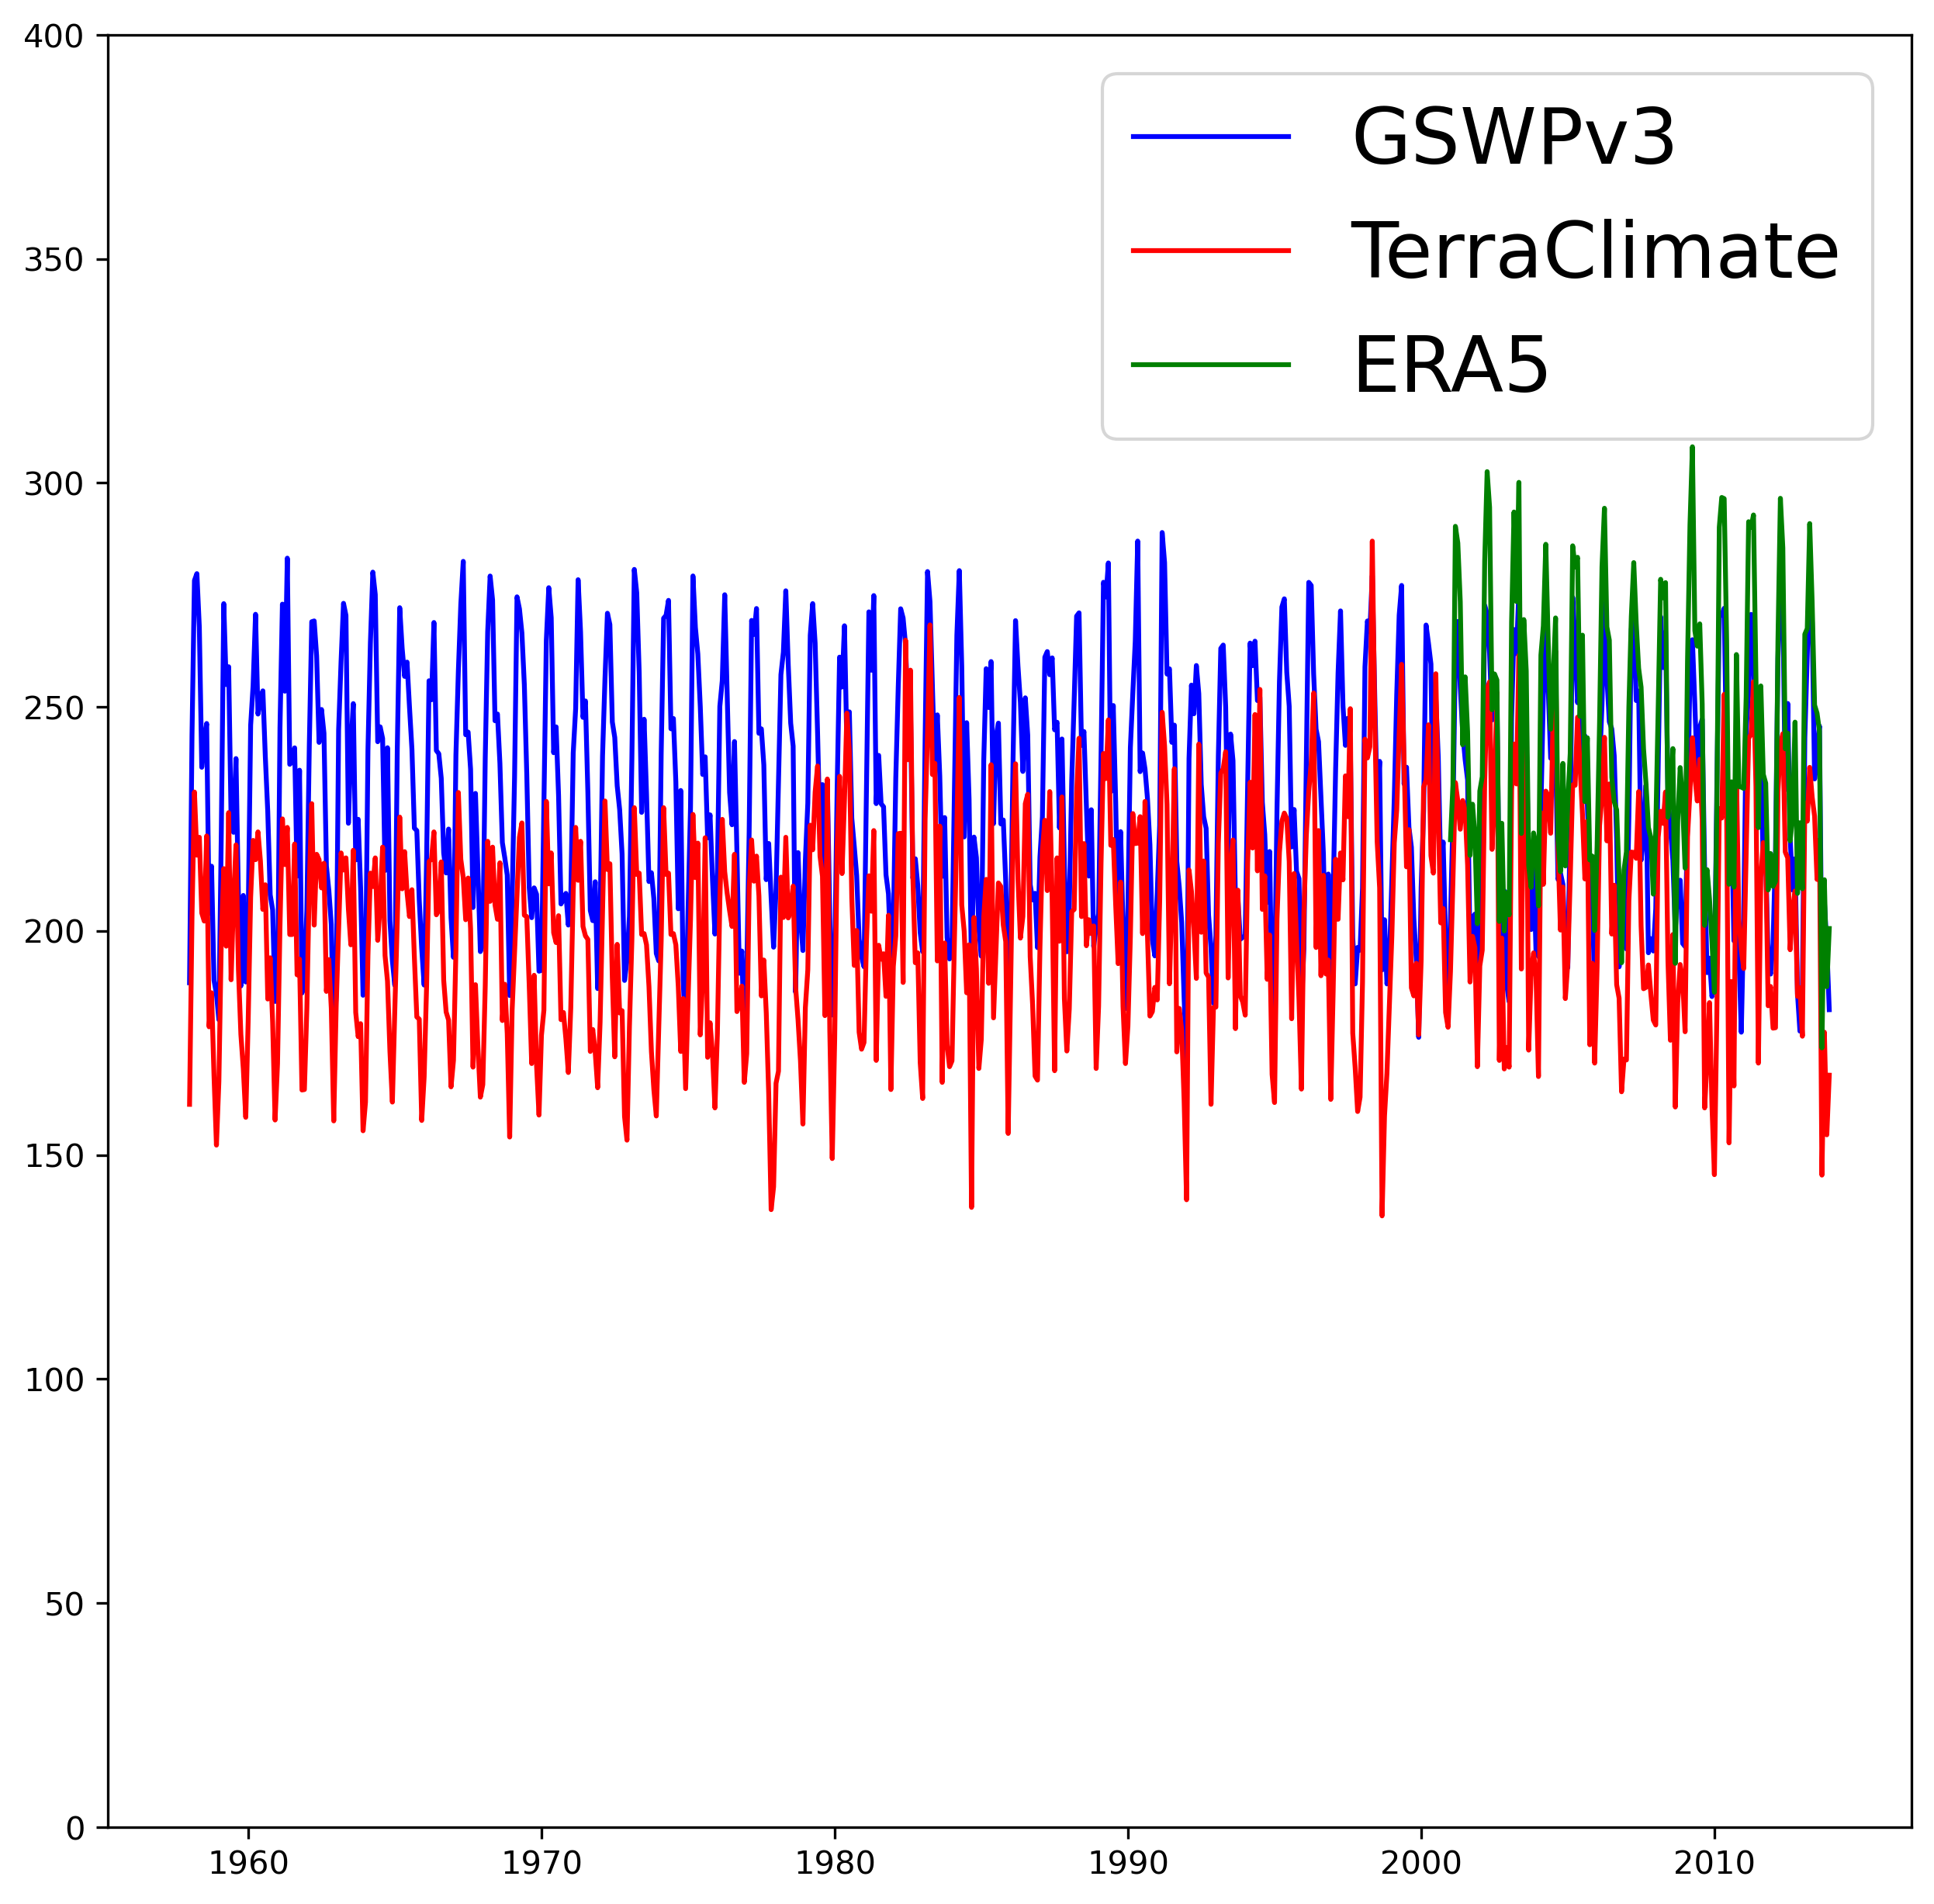

In [29]:
# Srad, W m-2, downward solar rad at surface, which maybe not compatible to GSWP3
fig = plt.figure(figsize=(10,10), dpi=300)
plt.plot(yr_axis, sr_rad[0:pltlen], 'b-')
plt.plot(yr_axis, sr_rad_terra[0:pltlen], 'r-')
# plt.plot(yr_axis2, sr_rad_era, 'g-')
plt.legend(['GSWPv3', 'TerraClimate', 'ERA5'], fontsize = 24)
plt.ylim([0, 400])

In [9]:
# Create dataframe
datasr = {'Time':yr_axis, 'Tmax':sr_tmax[0:pltlen]-273.16, 'Tmin':sr_tmin[0:pltlen]-273.16, 'Wind':sr_wind[0:pltlen], 'PREC':sr_prec[0:pltlen]*secs[0:pltlen], 'Srad':sr_rad[0:pltlen]}
datasr_terra = {'Time':yr_axis, 'Tmax':sr_tmax_terra[0:pltlen], 'Tmin':sr_tmin_terra[0:pltlen], 'Wind':sr_wind_terra[0:pltlen], 'PREC':sr_prec_terra[0:pltlen], 'Srad':sr_rad_terra[0:pltlen]}
datavm = {'Time':yr_axis, 'Tmax':vm_tmax[0:pltlen]-273.16, 'Tmin':vm_tmin[0:pltlen]-273.16, 'Wind':vm_wind[0:pltlen], 'PREC':vm_prec[0:pltlen]*secs[0:pltlen], 'Srad':vm_rad[0:pltlen]}
datavm_terra = {'Time':yr_axis, 'Tmax':vm_tmax_terra[0:pltlen], 'Tmin':vm_tmin_terra[0:pltlen], 'Wind':vm_wind_terra[0:pltlen], 'PREC':vm_prec_terra[0:pltlen], 'Srad':vm_rad_terra[0:pltlen]}
dfsr = pd.DataFrame(data=datasr)
dfsr_terra = pd.DataFrame(data=datasr_terra)
dfvm = pd.DataFrame(data=datavm)
dfvm_terra = pd.DataFrame(data=datavm_terra)

In [11]:
# San Rafael, Avg and Std
pd.concat([dfsr.mean().to_frame('Rio Frico GSWPv3, Avg'), dfsr.std().to_frame('Rio Frico GSWPv3, Std'), dfsr_terra.mean().to_frame('Rio Frico TerraClimate, Avg'), dfsr_terra.std().to_frame('Rio Frico TerraClimate, Std')], axis=1)

,"Rio Frico GSWPv3, Avg","Rio Frico GSWPv3, Std","Rio Frico TerraClimate, Avg","Rio Frico TerraClimate, Std"
Time,1985.958333,16.177831,1985.958333,16.177831
Tmax,24.184744,2.031609,18.953021,1.701493
Tmin,7.492257,2.489506,3.156012,2.458355
Wind,1.962472,0.223305,2.960432,0.298184
PREC,64.272243,62.720011,85.292262,81.399533
Srad,230.688019,27.838535,205.108036,25.366505


In [32]:
# Villa Madero, Avg and Std
pd.concat([dfvm.mean().to_frame('Villa Madero GSWPv3, Avg'), dfvm.std().to_frame('Villa Madero GSWPv3, Std'), dfvm_terra.mean().to_frame('Villa Madero TerraClimate, Avg'), dfvm_terra.std().to_frame('Villa Madero TerraClimate, Std')], axis=1)

,"Villa Madero GSWPv3, Avg","Villa Madero GSWPv3, Std","Villa Madero TerraClimate, Avg","Villa Madero TerraClimate, Std"
Time,1985.958333,16.177831,1985.958333,16.177831
Tmax,30.549368,2.798658,24.909286,2.331497
Tmin,13.342967,2.812602,9.354539,2.504798
Wind,2.116294,0.233252,2.039435,0.333481
PREC,87.137131,98.991671,92.409673,98.320599
Srad,237.614655,35.551281,210.632887,26.287957
